# Rosenbrock using Neighbourhood Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import voronoi_plot_2d, Voronoi

from napy import NASearcher, NAAppariser

The Rosenbrock function is a common optimisation test function given by 
$$f(x,y) = (a-x)^2 + b(y - x^2)^2$$
and has a global minimum at $(a, a^2)$

In [2]:
def rosenbrock(x, y, a=1, b=100):
    return np.log10((a - x) ** 2 + b * (y - x**2) ** 2)  # log10 to avoid very large/small values

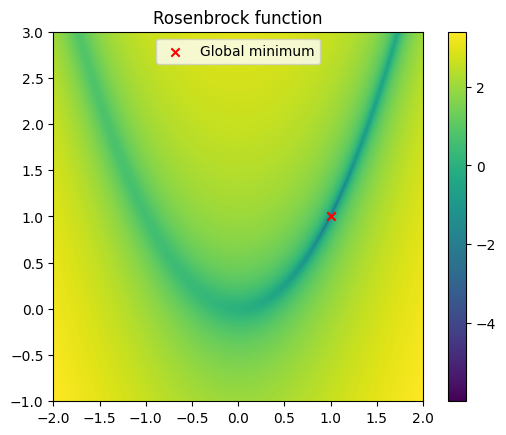

In [3]:
X, Y = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-1, 3, 1000))
plt.imshow(rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3))
plt.colorbar()
plt.scatter(1, 1, c="r", marker="x", label="Global minimum")
plt.title("Rosenbrock function")
plt.legend(loc="upper center")

### Neighbourhood Algorithm - Direct Search Phase

The first phase of the Neighbourhood Algorithm involves refining an approximation of the objective function.
The approximation is constructed using geometrical objects known as Voronoi cells.
As the algorithm progesses, more and more cells are created in the regions maximising/minimising the objective.

This is an approximate optimiser, that avoids the need to calculate gradients and only depends on the relative values of the objective function.

The direct search itself is perfomed in two stages.
 1. Initial random search - Uniformly sample the parameter space and evaluate the objective at these points
 2. Optimisation stage - Resample the parameter space in the neighbourhood of the best $n_r$ points. Evaluate the objective, rank and repeat.

In [4]:
def objective(params):
    return rosenbrock(*params)


searcher = NASearcher(
    objective,
    ns=70,
    nr=10,
    ni=100,
    n=20,
    bounds=((-2, 2), (-1, 3)),
)
searcher.run()

best = searcher.samples[np.argmin(searcher.objectives)]

(-1.0, 3.0)

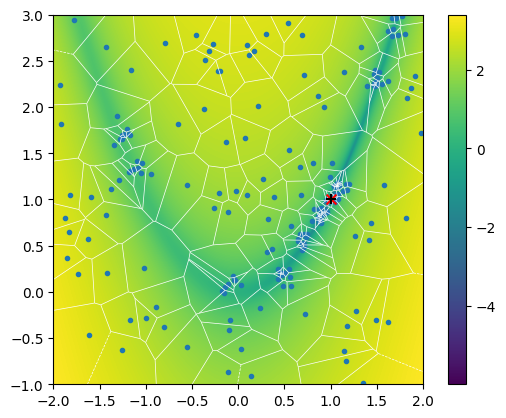

In [5]:

fig = voronoi_plot_2d(Voronoi(searcher.samples), show_vertices=False, line_width=0.5, line_colors="w")
ax = fig.gca()
im = ax.imshow(rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3))
fig.colorbar(im)
ax.scatter(1, 1, c="r", marker="x", s=50, zorder=10)
ax.scatter(*best, c="k", marker="+", s=50, zorder=10)
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 3)

Clearly the best fitting cell (black +) approximates the true optimum (red x) well.
Also notice how there is generally a higher concentration of cells in the vicinity of the parabolic valley.

### Neighbourhood Algorithm - Appraisal Phase

The first phase of the Neighbourhood Algorithm creates an approximation of the objective function.
Now we need to use this approximation to make probabilistic statements about the parameters involved.

The second phase of the Neighbourhood Algorithm resamples the approximation of the objective function, but importantly does not require any more evaluations of the objective function.
As such the parameter space can be sampled much faster.
Clearly, the extent to which the new samples will fit the original objective will depend on the quality of the approximation.

In [6]:
appraiser = NAAppariser(
    searcher.samples,
    np.exp(-searcher.objectives),
    bounds=((-2, 2), (-1, 3)),
    n_resample=5000,
    n_walkers=10,
)

results = appraiser.appraise(save=True)

Text(0.5, 1.0, 'NA-I and NA-II on Rosenbrock function')

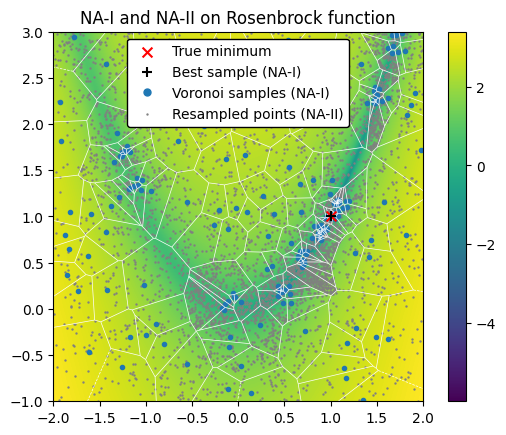

In [7]:
fig = voronoi_plot_2d(Voronoi(searcher.samples), show_vertices=False, line_width=0.5, line_colors="w")
ax = fig.gca()
im = ax.imshow(rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3))
fig.colorbar(im)
_truth = ax.scatter(1, 1, c="r", marker="x", s=50, zorder=2, label="True minimum")
_best = ax.scatter(*best, c="k", marker="+", s=50, zorder=2, label="Best sample (NA-I)")
_resample = ax.scatter(
    *results["samples"].T, s=0.5, c="grey", zorder=0, label="Resampled points (NA-II)"
)
_voronoi = Line2D([0], [0], marker="o", label="Voronoi samples (NA-I)", markersize=5, linewidth=0)

ax.set_xlim(-2, 2)
ax.set_ylim(-1, 3)
ax.legend(
    handles=[_truth, _best, _voronoi, _resample],
    framealpha=1,
    edgecolor="black",
)
ax.set_title("NA-I and NA-II on Rosenbrock function")

Text(0.5, 0.98, 'Conditional distributions form NA-II on Rosenbrock function')

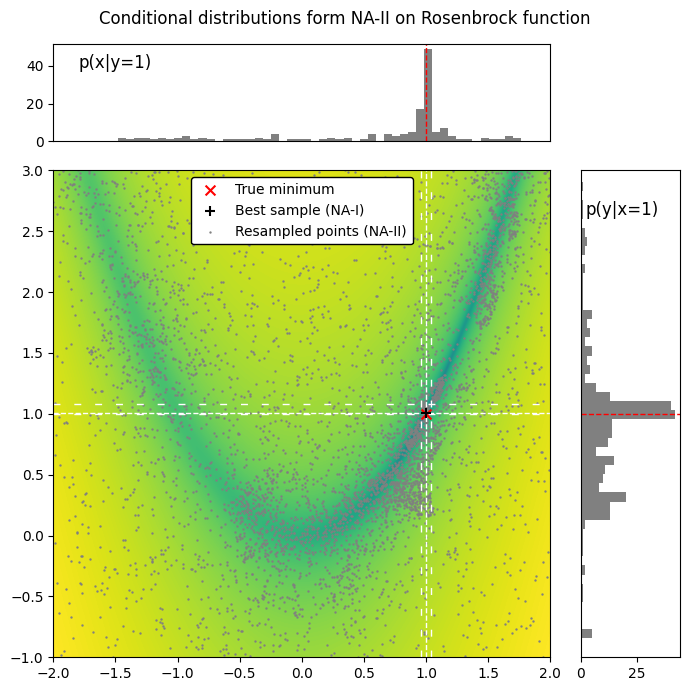

In [8]:
fig, axs = plt.subplots(
    2,
    2,
    gridspec_kw=dict(height_ratios=[1, 5], width_ratios=[5, 1]),
    figsize=(7, 7),
    tight_layout=True,
)
axs[0, 1].set_visible(False)


# Conditional posterior samples p(x|y=1)
y_hist_edges = np.histogram_bin_edges(results["samples"][:, 1], bins=50, range=(-1, 3))
best_ind_y = np.digitize(1, y_hist_edges)
x_given_y = results["samples"][
    (results["samples"][:, 1] > y_hist_edges[best_ind_y - 1])
    & (results["samples"][:, 1] < y_hist_edges[best_ind_y]),
    0,
]
axs[0, 0].hist(x_given_y, bins=50, orientation="vertical", color="grey")
axs[0, 0].axvline(1, c="r", ls="--", lw=1)
axs[0, 0].set_xlim(-2, 2)
axs[0, 0].set_xticks([])
axs[0, 0].text(
    0.05,
    0.9,
    "p(x|y=1)",
    transform=axs[0, 0].transAxes,
    fontsize=12,
    verticalalignment="top",
)

# Conditional posterior samples p(y|x=1)
x_hist_edges = np.histogram_bin_edges(results["samples"][:, 0], bins=50, range=(-2, 2))
best_ind_x = np.digitize(1, x_hist_edges)
y_given_x = results["samples"][
    (results["samples"][:, 0] > x_hist_edges[best_ind_x - 1])
    & (results["samples"][:, 0] < x_hist_edges[best_ind_x]),
    1,
]
axs[1, 1].hist(y_given_x, bins=50, orientation="horizontal", color="grey")
axs[1, 1].axhline(1, c="r", ls="--", lw=1)
axs[1, 1].set_ylim(-1, 3)
axs[1, 1].set_yticks([])
axs[1, 1].text(
    0.05,
    0.9,
    "p(y|x=1)",
    transform=axs[1, 1].transAxes,
    fontsize=12,
    verticalalignment="bottom",
)

# Full posterior samples
im = axs[1, 0].imshow(
    rosenbrock(X, Y), origin="lower", extent=(-2, 2, -1, 3), aspect="auto"
)
_truth = axs[1, 0].scatter(
    1, 1, c="r", marker="x", s=50, zorder=2, label="True minimum"
)
_best = axs[1, 0].scatter(
    *best, c="k", marker="+", s=50, zorder=2, label="Best sample (NA-I)"
)
_resample = axs[1, 0].scatter(
    *results["samples"].T, s=0.5, c="grey", zorder=0, label="Resampled points (NA-II)"
)
axs[1, 0].axvline(best[0], c="w", ls="--", lw=1, zorder=1)
axs[1, 0].axvline(x_hist_edges[best_ind_x - 1], c="w", ls=(0, (5, 10)), lw=1, zorder=1)
axs[1, 0].axvline(x_hist_edges[best_ind_x], c="w", ls=(0, (5, 10)), lw=1, zorder=1)
axs[1, 0].axhline(best[1], c="w", ls="--", lw=1, zorder=1)
axs[1, 0].axhline(y_hist_edges[best_ind_y - 1], c="w", ls=(0, (5, 10)), lw=1, zorder=1)
axs[1, 0].axhline(y_hist_edges[best_ind_y], c="w", ls=(0, (5, 10)), lw=1, zorder=1)
axs[1, 0].set_xlim(-2, 2)
axs[1, 0].set_ylim(-1, 3)
axs[1, 0].legend(
    handles=[_truth, _best, _resample],
    framealpha=1,
    edgecolor="black",
)

fig.suptitle("Conditional distributions form NA-II on Rosenbrock function")